### Import packages

In [ ]:
import tensorflow as tf
print("TensorFlow", tf.__version__)

import os
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.io import parse_tensor

import time
import datetime

# For visualizations
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython import display
import glob
import imageio
import PIL

### Global paths for data loading and model saving

In [ ]:
# Serialized dataset path
# Tensors are embeddings by SeqVec
serialized_tensors_seqvec = 'Rhodopsin generation/processed/TFRecord_SerializedObjects_SeqVec'

savepath = 'Rhodopsin generation/GANs/'
modelspath  = 'Rhodopsin generation/GANs/models'
checkpointpath  = 'Rhodopsin generation/GANs/checkpoints'

# For tensors generated during training, to see how proteins became more natural
generated_tensors_during_training = 'Rhodopsin generation/GANs/gentensors/seqvec'

### Data loading and preprocessing

In [ ]:
# Batch size
BATCH_SIZE = 128

# (Lenght of Protein) x (Dimension of SeqVec embeddings) 400x1024 
L = 400
embedding_dim = 1024
clades_num = 26

In [ ]:
serialized_tensors = serialized_tensors_seqvec

filenames = [serialized_tensors + '/' + file for file in os.listdir(serialized_tensors)]
raw_dataset = tf.data.TFRecordDataset(filenames)

def parse_example(example):
  example_proto = tf.train.Example()
  example_proto.ParseFromString(example.numpy())
  features = example_proto.features.feature
  label = parse_tensor(features['label'].bytes_list.value[0], out_type = tf.float32)
  tensor = parse_tensor(features['tensor'].bytes_list.value[0], out_type = tf.float32)
  return tf.argmax(label), tf.reduce_mean(tensor, axis=0)

def parsed_dataset_generator():
  for i in raw_dataset:
    yield parse_example(i)

parsed_dataset = tf.data.Dataset.from_generator(
     parsed_dataset_generator,
     (tf.int64, tf.float32),
     (tf.TensorShape([]), tf.TensorShape([embedding_dim, ]))).batch(BATCH_SIZE)

### Learning hyperparameters

In [ ]:
# Dimension of latent space, where seeds for proteins come from
latent_dim = 100 

# DNN parameters
dropout_rate = 0.3
dense_dim = 128

## Create the models and define Loss-functions

### The generator
The generator is aimed to *generate* vectors of shape (1024, ) (SeqVec embeddings length), which represent rhodopsin sequence

In [ ]:
def make_generator_model():
  input_z = layers.Input(shape=(latent_dim,))

  x = layers.Dense(dense_dim, use_bias=False, input_shape=(latent_dim,))(input_z)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Dense(2*dense_dim, use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Dense(2*2*dense_dim, use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  output = layers.Dense(embedding_dim, use_bias=False)(x)

  model = tf.keras.Model(input_z, output, name="generator")

  return model

In [ ]:
generator = make_generator_model()

input_z = tf.random.normal([BATCH_SIZE, latent_dim])
generated_embedding = generator(input_z, training=False)

generated_embedding

<tf.Tensor: shape=(128, 1024), dtype=float32, numpy=
array([[-0.08621431,  0.26281923,  0.24474712, ..., -0.27950823,
        -0.23237364, -0.3346402 ],
       [-0.10151209, -0.04200742,  0.03006314, ...,  0.00212605,
        -0.5969251 , -0.01297479],
       [ 0.01667298,  0.21596017,  0.08674801, ...,  0.01408926,
         0.07614811, -0.2443341 ],
       ...,
       [ 0.02098741,  0.11482619,  0.10433593, ..., -0.12898807,
        -0.09372294, -0.4027245 ],
       [-0.13588631,  0.27771425,  0.02537064, ..., -0.00722599,
        -0.32470238,  0.01280212],
       [-0.13895339, -0.12354487, -0.17490868, ..., -0.20219065,
        -0.11410799, -0.42112428]], dtype=float32)>

In [ ]:
def make_discriminator_model():
  input_emb = layers.Input(shape=(embedding_dim,))

  x = layers.Dense(2*dense_dim)(input_emb)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Dense(dense_dim)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Dense(dense_dim/2)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(dropout_rate)(x)

  output = layers.Dense(1)(x)

  model = tf.keras.Model(input_emb, output, name="discriminator")

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_embedding)
print (decision)

tf.Tensor(
[[ 8.36864710e-02]
 [-2.56602436e-01]
 [-2.14657970e-02]
 [-1.80977240e-01]
 [-1.18756883e-01]
 [-1.25419535e-02]
 [-2.03283429e-02]
 [-1.51661128e-01]
 [-7.81065524e-02]
 [-1.34831160e-01]
 [-9.65057164e-02]
 [ 8.09535682e-02]
 [ 1.44857228e-01]
 [-2.78771557e-02]
 [ 1.68840930e-01]
 [-1.05850650e-02]
 [ 3.01210117e-02]
 [ 7.48676062e-02]
 [ 5.45534417e-02]
 [-2.20032364e-01]
 [-5.29255718e-02]
 [-1.83343533e-02]
 [ 6.75737262e-02]
 [-2.74301052e-01]
 [ 1.82189010e-02]
 [-1.86658263e-01]
 [-3.60207856e-01]
 [-1.57483026e-01]
 [ 3.00425701e-02]
 [ 1.68999404e-01]
 [ 3.18370275e-02]
 [ 5.53617962e-02]
 [ 3.03149998e-01]
 [ 3.11417524e-02]
 [ 1.38942242e-01]
 [ 1.07469931e-01]
 [ 6.07231669e-02]
 [ 1.83582716e-02]
 [-1.09897248e-01]
 [-1.36235848e-01]
 [-2.16284364e-01]
 [ 1.01027273e-01]
 [-1.07405022e-01]
 [-2.03862116e-01]
 [-5.04569471e-01]
 [-9.76639912e-02]
 [-3.54223400e-01]
 [-2.49940846e-02]
 [ 9.16400701e-02]
 [-3.70309770e-01]
 [-2.46499613e-01]
 [ 2.18998268e-01]
 

### Loss-functions and optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator loss is lower, when real-output returns 1, and fake-output (of generator) returns 0. Thus optimizer will make discriminator to verify natural proteins better 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss is lower, when its fake-output returns 1. Thus optimizer will make generator to generate proteins closer to natural 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints

In [ ]:
checkpoint_prefix = os.path.join(checkpointpath, 'seqvec', "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define training step

In [ ]:
EPOCHS = 10000
num_proteins_to_generate_per_clade = 10

# We will reuse this seed overtime (so it's easier)

seed = tf.random.normal([num_proteins_to_generate_per_clade*clades_num, latent_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    real_labels, real_examples = batch
    batch_size = real_examples.shape[0]

    generator_inputs = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_examples = generator(generator_inputs, training=True)

      real_output = discriminator(real_examples, training=True)
      fake_output = discriminator(fake_examples, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  start_time = datetime.datetime.now()
  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      train_step(batch)

    if (epoch + 1) % 100 == 0:
      generate_and_save_tensors(generator,
                                start_time,
                                epoch + 1,
                                seed)

    # Save the model every 100 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print ('After epoch {}:\n Discriminator loss:: {:+.2f}. Generator loss:: {:+.2f}'.format(epoch + 1, disc_loss, gen_loss))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_tensors(generator,
                            start_time,
                            epochs,
                            seed)

In [ ]:
def generate_and_save_tensors(model, start_time, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  np.savetxt(os.path.join(generated_tensors_during_training, 'seqvec', start_time.strftime('%y-%m-%d-%Hh_E{:04d}.csv').format(epoch)), predictions, delimiter=',')

In [ ]:
train(parsed_dataset, EPOCHS)

## Visualization

#### Train data preparation

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
     parsed_dataset_generator,
     (tf.int64, tf.float32),
     (tf.TensorShape([]), tf.TensorShape([1900,])))

In [ ]:
real_tensors = []
real_labels = []

for label, tensor in train_dataset.as_numpy_iterator():
  real_tensors.append(tensor)
  real_labels.append(label)

real_tensors = np.array(real_tensors)
real_labels = np.array(real_labels)

#### t-SNE visualization 

In [ ]:
def take_part(num_elements, part, seed = None):
  if seed: np.random.seed(seed)
  indices = np.arange(0, num_elements)
  np.random.shuffle(indices)
  return indices[:round(num_elements * part)]

def tsne_transform(tensors, labels, part = 1, seed=None, **kwargs):
  # taking part of data
  indices = take_part(labels.shape[0], part, seed=seed) 
  subTensors = tensors[indices]
  subLabels = labels[indices]    

  # define t-SNE model
  tsne = TSNE(**kwargs)
  tsne_representation = tsne.fit_transform(subTensors)

  return tsne_representation, subLabels

def tsne_vis(tsne_representation, labels, ax=plt, title = 't-SNE visualization', color_list = None, alpha=0.5, save_to_file = None):
  if not color_list:
    colors = cm.gist_ncar(np.linspace(0, 1, len(set(labels))+1));
  else:
    colors = color_list

  for i, lab in enumerate(set(labels)):
    if type(alpha) == list:
      ax.scatter(tsne_representation[list(np.where(labels==lab)[0]), 0], tsne_representation[list(np.where(labels==lab)[0]), 1], color=colors[i], alpha=alpha[i], label=str(lab));   
    else:
      ax.scatter(tsne_representation[list(np.where(labels==lab)[0]), 0], tsne_representation[list(np.where(labels==lab)[0]), 1], color=colors[i], alpha=alpha, label=str(lab));

  if ax == plt:
    ax.title(title, size=30)
  else:
    ax.set_title(title, size=30)
  # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

  if save_to_file:
    plt.savefig(save_to_file, pad_inches=0)

In [ ]:
ts, ys = tsne_transform(real_tensors, real_labels, part = 0.1, seed=1, random_state = 123)

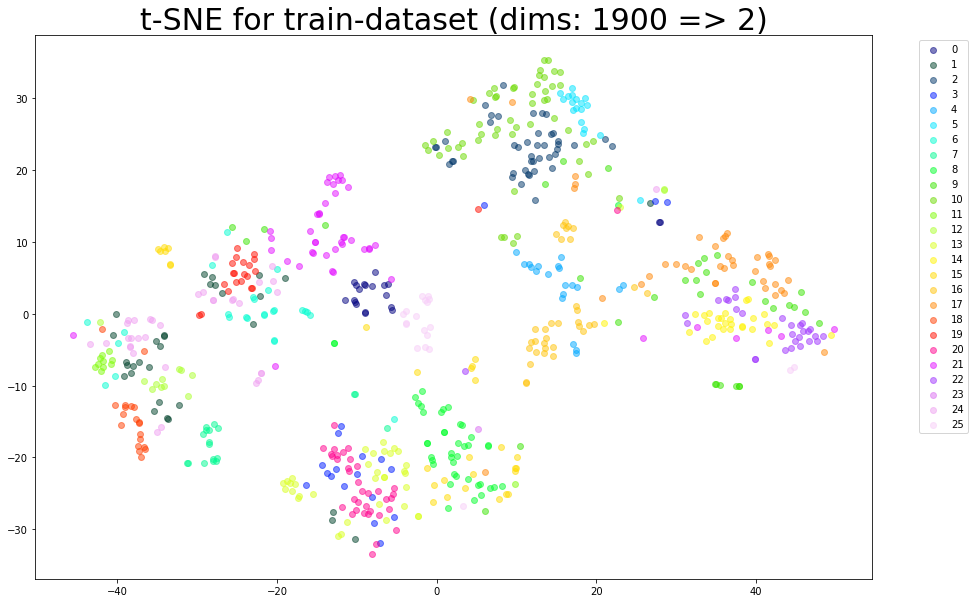

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10));
tsne_vis(ts, ys,  ax = axes)